In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from collections import defaultdict
from scipy.sparse import dok_matrix, csr_matrix
from sklearn.preprocessing import normalize
import networkx as nx
import itertools
from itertools import islice
from tqdm.notebook import tqdm
from matplotlib.patches import Patch
import scipy as sp
import math
import csv
from collections import OrderedDict
import sys
import matplotlib.cm as cm
import matplotlib.colors as colors

L = 16
df = pd.read_csv("../../Kd_Inference/results_CH65/Kd_processed/20220603_CH65_QCfilt_REPfilt.csv",
                 dtype={"geno":"str"})
df["geno_int"] = df.geno.apply(lambda x: int(x, 2))

df = df.set_index("geno_int").reindex(range(0, 2**L)).reset_index()
sequences_int = range(0,2**L)
for ii in range(L):
    df[f"mutation_{ii+1}"] = df.geno.str[ii] == '1'


colors = ["#66c2bd", "#1b9d9b", "#fc7864", "#d94602", "#8DA0CB","#7570B3","#E78AC3","#E7298A","#A6D854","#66A61E","#FFD92F","#E6AB02","#E5C494","#A6761D","#B3B3B3","#666666"]

# change antigen
df["log10Kd"] = df.SI06_mean


# mutations considered
ks = [2,6,8,9,10]
# comment that to do the mean rather than the single-mutant
df = df[df.geno.apply(lambda x: all([x[i] == '0' for i in range(L) if i not in ks]))].copy()

/Users/angelaphillips/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/angelaphillips/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/angelaphillips/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):
/Users/angelaphillips/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed

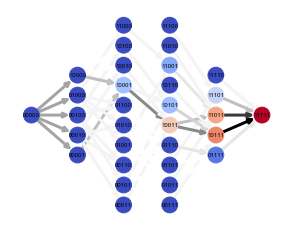

In [17]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, LogNorm
from sklearn.preprocessing import normalize

def fixation_probability_moderate(fitness_s,fitness_t,Npop,gamma):
    if np.isnan(fitness_s) or np.isnan(fitness_t):
        pval = 0.0
    else:
        delta = fitness_t - fitness_s
        if delta == 0.0:
            pval = 1.0/Npop
        elif Npop*gamma*delta > -100:
            pval = ((1 - np.exp(-gamma*delta))/(1 - np.exp(-Npop*gamma*delta)))
        else:
            pval = 0
    return pval
def nb_mutation(s):
    """ Number of mutations in variant s """
    return bin(s).count("1")

def reachable(s, L):
    return [(s | 2**ii) for ii in range(L) if (s | 2**ii) > s]


# mutations considered
# ks = [2,3,4,7,9]

def locus(x):
    st = ""
    for k in ks:
        st += x[k]
    return st

dft = df.copy()
dft["locus"] = dft.geno.apply(locus)
fitness = dft.set_index("locus").log10Kd.to_dict()


G = nx.DiGraph()
G.add_nodes_from(["".join(a) for a in itertools.product('01', repeat=len(ks))])

cma =  cm.get_cmap('Greys', 12)

minlogkd=np.inf
maxlogkd=-np.inf

fitness = dft.groupby("locus").log10Kd.mean()
pmut = np.matrix(np.zeros((2**len(ks), 2**len(ks))))
for s in [int(u, 2) for u in G.nodes]:
    for t in reachable(s, len(ks)):
        pmut[s, t] = fixation_probability_moderate(fitness[s],fitness[t],100,0.1)
pmut = normalize(np.array(pmut), norm='l1', axis=1)
pmut = np.matrix(pmut)
qmut = np.matrix(np.zeros((2**len(ks), 2**len(ks))))
for s in [int(u, 2) for u in G.nodes]:
    for t in reachable(s, len(ks)):
        nb = nb_mutation(s)
        qmut[s, t] = (pmut**(nb))[0, s] * pmut[s, t]
     
#norm = LogNorm(vmin=1e-10, vmax=1)
qmut = qmut/np.max(qmut)
for a in G.nodes:
    for b in G.nodes:
        w = qmut[int(a,2), int(b,2)]
        if w != 0:
            #w = np.log(w) - np.log(np.ma.masked_equal(qmut, 0.0, copy=False).min())
            #print(a, b, w)
            G.add_edge(a, b, 
                    weight = 1,
                    colr = cma(w))

dct = {}
posy = {}
for a in G.nodes:
    if a.count('1') not in dct:
        dct[a.count('1')] = 0
        posy[a] = 0
    else:
        dct[a.count('1')] += 1
        posy[a] = dct[a.count('1')]
        
for a in G.nodes:
    posy[a] -= dct[a.count('1')]/2

mut_names = ks
node_labels = {a: "".join([a[i]
                           for i, k in enumerate(ks)]) for a in G.nodes}

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
nx.draw_networkx(G, pos={a:(a.count('1'), posy[a]) for a in G.nodes}, width=0,
                 with_labels=True, labels=node_labels,  node_size=250, 
                 node_color=[fitness[a] for a in G], cmap="coolwarm", edge_color='w', arrows=False,
                 font_size=6, font_family='Arial', ax=ax)

nx.draw_networkx_edges(G, pos={a:(a.count('1'), posy[a]) for a in G.nodes}, 
                 width=[2*nx.get_edge_attributes(G, 'weight')[a] +1 for a in G.edges],
                 edge_color=[nx.get_edge_attributes(G, 'colr')[a] for a in G.edges],
                 ax=ax,
                      arrows=True, arrowsize=10,node_size=250 )

ax.axis('off')
plt.savefig('images/SI06_epistasis_web.png',dpi=1200)
plt.show()